In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
44360,NaN,NaN,International,2020-09-15,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44361,NaN,NaN,International,2020-09-16,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44362,NaN,NaN,International,2020-09-17,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


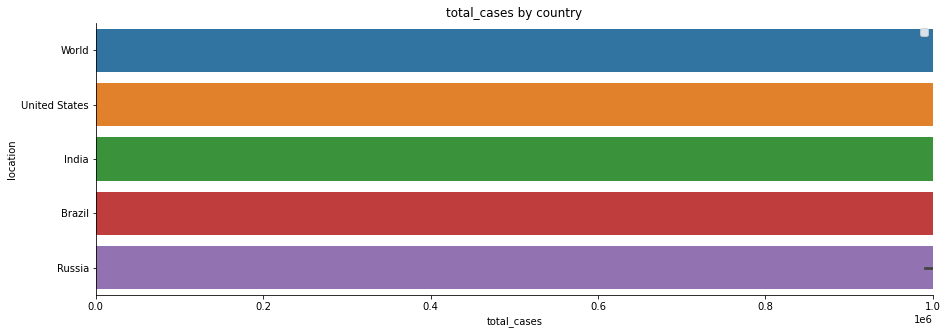

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


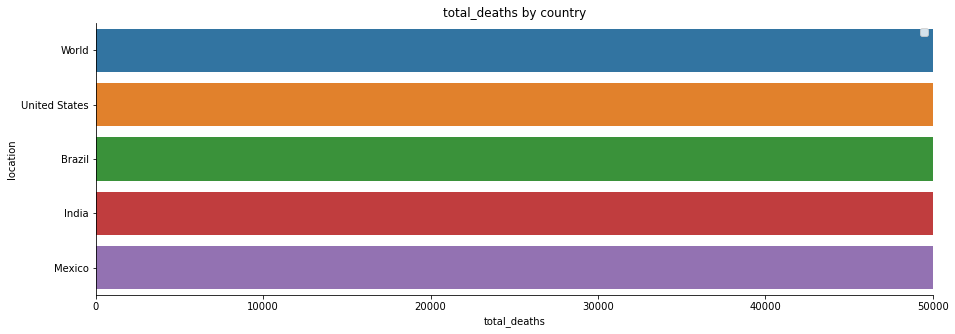

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


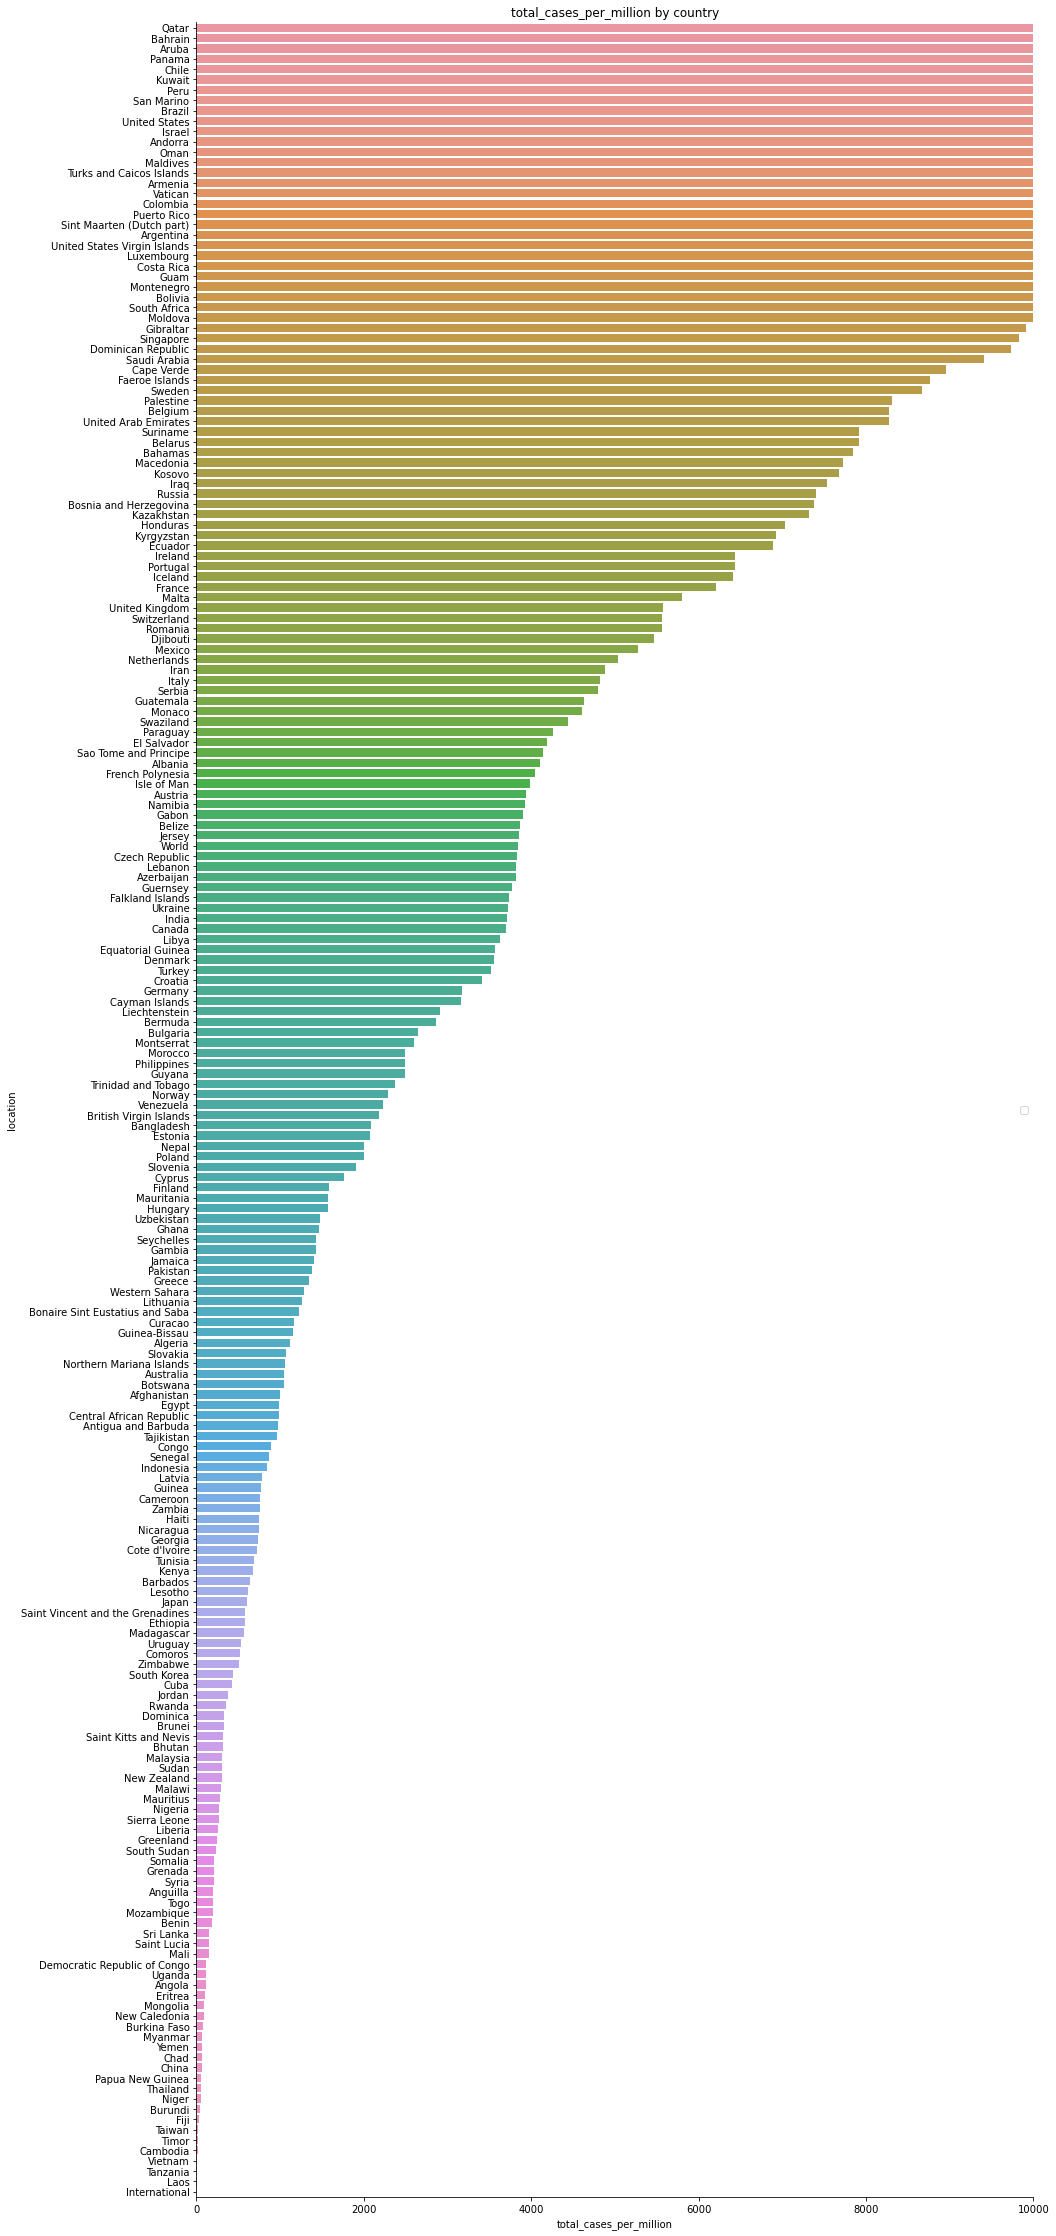

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


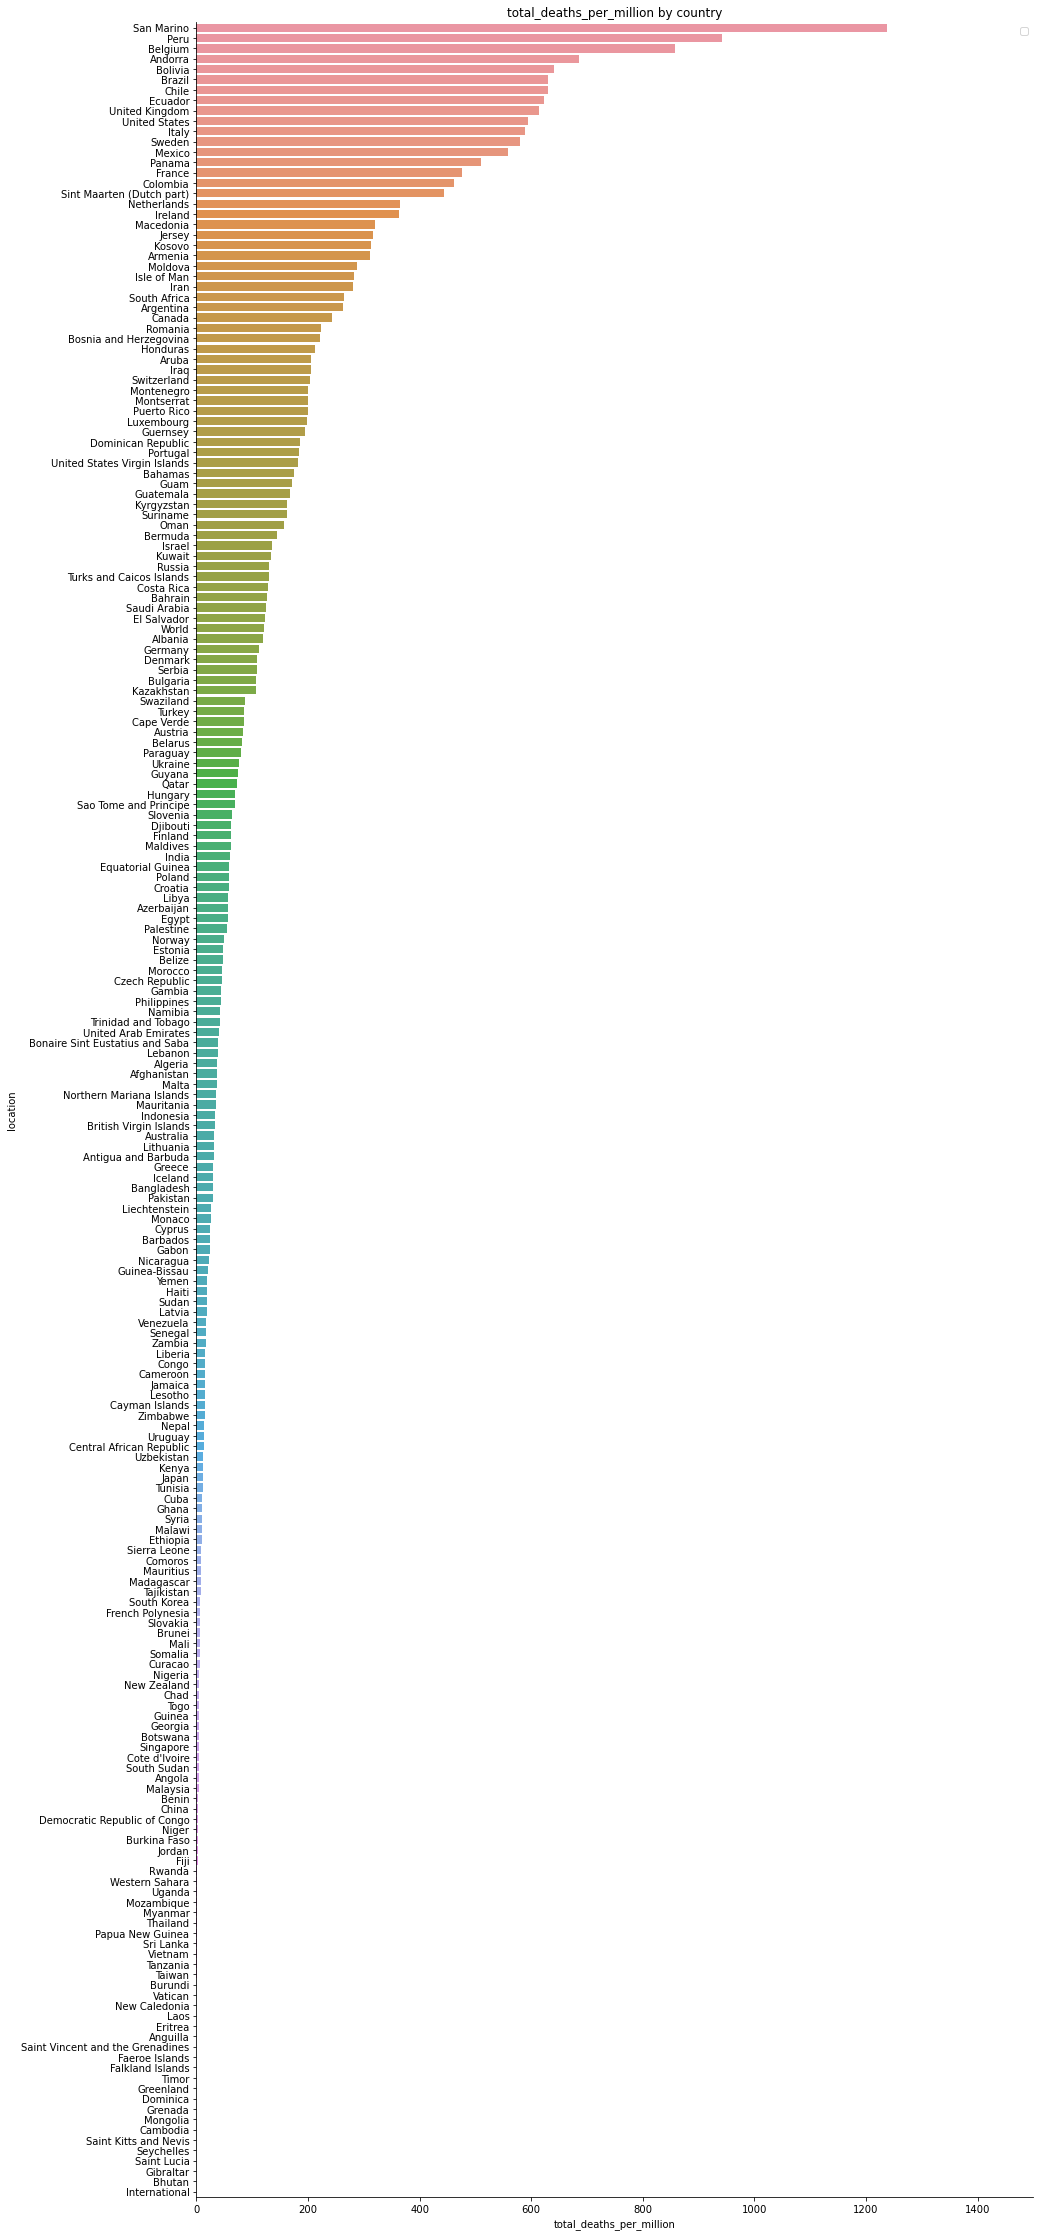

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

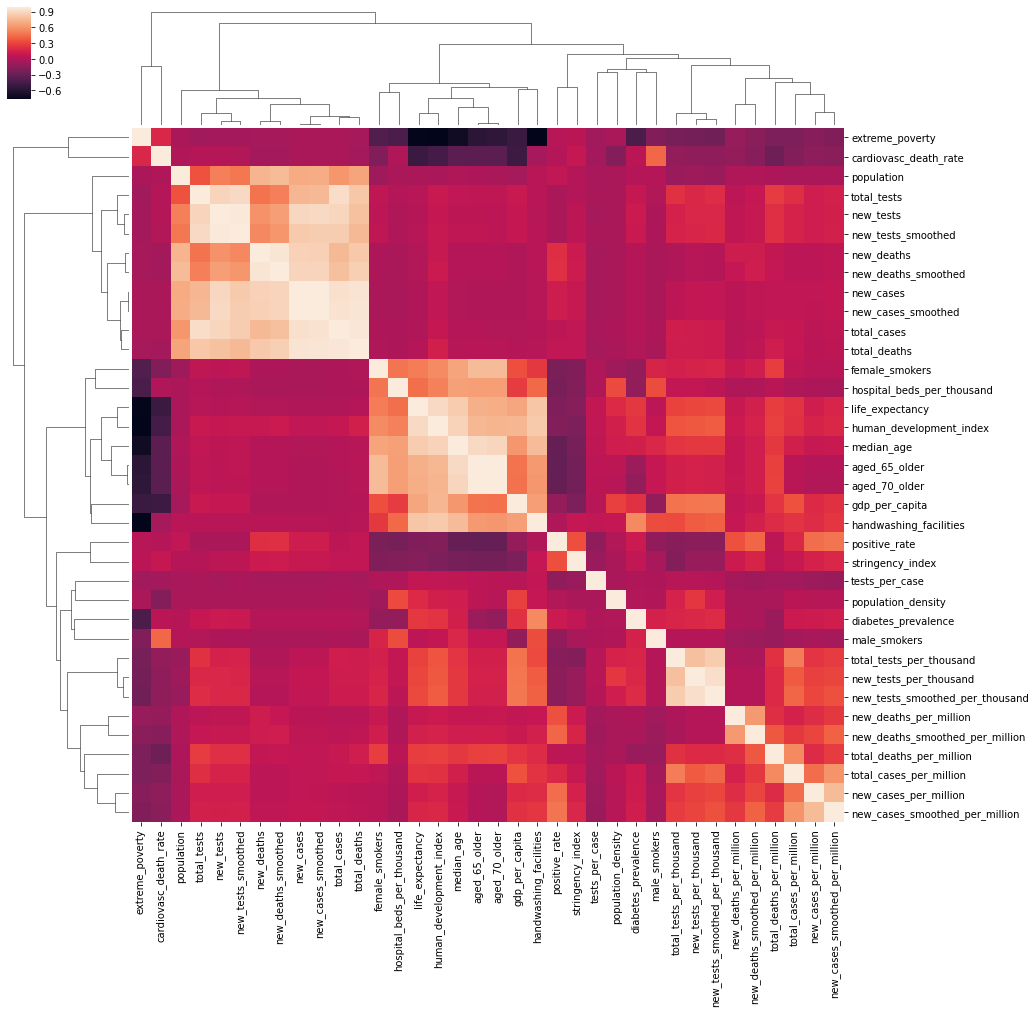

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9988009124691958 (+/- 0.0015042513883308192)
Coef :  [1.03262116e+00 8.82686767e-05 9.06463363e-05]
3 Last_days :  [[29321328 29623970 29902487]]
Today :  29902487
Prediction + :  480384
Tomorow :  30382871
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996798266277667 (+/- 0.00010286144579295559)
Coef :  [0.18219104 0.40256792 0.42541181]
3 Last_days :  [[929063 936019 941291]]
Today :  941291
Prediction + :  8365
Tomorow :  949656
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: -0.09820780818137005 (+/- 1.5490384916317836)
Coef :  [-0.75059594  0.78922166  0.96574008]
3 Last_days :  [[387252 395104 404888]]
Today :  404888
Prediction + :  7277
Tomorow :  412165
                                     
--------- Total Death -----------------
                                     
R^2: 0.8913985469755517 (+/- 0.14380787296747177)
Coef :  [-0.7481268   0.78843864  0.95866192]
3 Last_days :  [[30950 30999 31045]]
Today :  31045
Prediction + :  56
Tomorow :  31101
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9591288572063505 (+/- 0.03568580280280337)
Coef :  [-0.32880149 -0.012403    1.33546875]
3 Last_days :  [[90219 90243 90250]]
Today :  90250
Prediction + :  20
Tomorow :  90270
                                     
--------- Total Death -----------------
                                     
R^2: -75.88670367203768 (+/- 108.6315361021564)
Coef :  [-0.07747615  0.01247267  1.05675825]
3 Last_days :  [[4735 4736 4736]]
Today :  4736
Prediction + :  5
Tomorow :  4741
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9322328809555716 (+/- 0.09485136773252593)
Coef :  [-0.81527978  0.89415837  0.92050635]
3 Last_days :  [[288761 289990 291442]]
Today :  291442
Prediction + :  1107
Tomorow :  292549
                                     
--------- Total Death -----------------
                                     
R^2: -0.052784369717572645 (+/- 1.4655064218484752)
Coef :  [-0.82202819  0.89639713  0.92465613]
3 Last_days :  [[35624 35633 35645]]
Today :  35645
Prediction + :  27
Tomorow :  35672
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.5812144362573847 (+/- 0.5832252392985248)
Coef :  [-0.31004068  0.16222301  1.15418729]
3 Last_days :  [[593730 603167 614360]]
Today :  614360
Prediction + :  8633
Tomorow :  622993
                                     
--------- Total Death -----------------
                                     
R^2: 0.10315501599489718 (+/- 0.9670527470151657)
Coef :  [-0.72981666  0.63939834  1.08950098]
3 Last_days :  [[29848 30004 30243]]
Today :  30243
Prediction + :  145
Tomorow :  30388
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9661622803795601 (+/- 0.04662804580767064)
Coef :  [0.09442347 0.45721164 0.46121522]
3 Last_days :  [[6554820 6606293 6630891]]
Today :  6630891
Prediction + :  83865
Tomorow :  6714756
                                     
--------- Total Death -----------------
                                     
R^2: 0.9881009049091546 (+/- 0.015525424481675976)
Coef :  [-0.43142076  0.68395267  0.75025859]
3 Last_days :  [[194530 195937 196802]]
Today :  196802
Prediction + :  1353
Tomorow :  198155
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9996980684277629 (+/- 0.00014913893233098766)
Coef :  [-0.68077538  0.82865106  0.85284166]
3 Last_days :  [[371125 374228 378219]]
Today :  378219
Prediction + :  2373
Tomorow :  380592
                                     
--------- Total Death -----------------
                                     
R^2: 0.25382145980310966 (+/- 1.0114471540203458)
Coef :  [-0.76601418  0.83049508  0.93479991]
3 Last_days :  [[41637 41664 41684]]
Today :  41684
Prediction + :  53
Tomorow :  41737
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.29497962986868875 (+/- 0.9960918607768682)
Coef :  [-0.78128088  0.85029419  0.9308961 ]
3 Last_days :  [[261762 263663 265857]]
Today :  265857
Prediction + :  1628
Tomorow :  267485
                                     
--------- Total Death -----------------
                                     
R^2: 0.26317775813555727 (+/- 1.0331530967262745)
Coef :  [-0.78550955  0.83948464  0.94524936]
3 Last_days :  [[9362 9368 9371]]
Today :  9371
Prediction + :  10
Tomorow :  9381
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9922732229247521 (+/- 0.009066016708807061)
Coef :  [0.30547478 0.35422743 0.35095136]
3 Last_days :  [[404648 407353 410334]]
Today :  410334
Prediction + :  3154
Tomorow :  413488
                                     
--------- Total Death -----------------
                                     
R^2: 0.9139650377442594 (+/- 0.12104341517470053)
Coef :  [0.09769576 0.46184367 0.45122887]
3 Last_days :  [[23313 23453 23632]]
Today :  23632
Prediction + :  206
Tomorow :  23838
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9996319127877475 (+/- 0.0002763407743963876)
Coef :  [-0.6592752   0.81317169  0.84351857]
3 Last_days :  [[292878 294620 296391]]
Today :  296391
Prediction + :  1343
Tomorow :  297734
                                     
--------- Total Death -----------------
                                     
R^2: 0.9994418298512081 (+/- 0.0003214092858030663)
Coef :  [-0.81375277  0.89327247  0.91846677]
3 Last_days :  [[7119 7186 7249]]
Today :  7249
Prediction + :  54
Tomorow :  7303
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8826655080584018 (+/- 0.16341054967860927)
Coef :  [-0.15652079  0.52321814  0.64583396]
3 Last_days :  [[4345610 4382263 4419083]]
Today :  4419083
Prediction + :  55408
Tomorow :  4474491
                                     
--------- Total Death -----------------
                                     
R^2: 0.46269647816737774 (+/- 0.7570569086651423)
Coef :  [-0.06353638  0.50136097  0.57283192]
3 Last_days :  [[132006 133119 134106]]
Today :  134106
Prediction + :  1384
Tomorow :  135490
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(29902487, 941291, 30382871, 949656),
 (404888, 31045, 412165, 31101),
 (291442, 35645, 292549, 35672),
 (614360, 30243, 622993, 30388),
 (6630891, 196802, 6714756, 198155),
 (90250, 4736, 90270, 4741),
 (378219, 41684, 380592, 41737),
 (265857, 9371, 267485, 9381),
 (410334, 23632, 413488, 23838),
 (296391, 7249, 297734, 7303),
 (4419083, 134106, 4474491, 135490)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-17,France,412165.0,0.0,31101.0,0.0,0.0,0.0
0,2020-09-17,China,90270.0,0.0,4741.0,0.0,0.0,0.0
0,2020-09-17,Italy,292549.0,0.0,35672.0,0.0,0.0,0.0
0,2020-09-17,Spain,622993.0,0.0,30388.0,0.0,0.0,0.0
0,2020-09-17,United States,6714756.0,0.0,198155.0,0.0,0.0,0.0
0,2020-09-17,World,30382871.0,0.0,949656.0,0.0,0.0,0.0
0,2020-09-17,United Kingdom,380592.0,0.0,41737.0,0.0,0.0,0.0
0,2020-09-17,Germany,267485.0,0.0,9381.0,0.0,0.0,0.0
0,2020-09-17,Iran,413488.0,0.0,23838.0,0.0,0.0,0.0
0,2020-09-17,Turkey,297734.0,0.0,7303.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")